In [53]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [54]:
# Load the data
data = pd.read_csv('generated_data.csv')

In [55]:
data

,Appointment ID,Patient ID,Patient Age,Patient Gender,Patient Health Condition,Previous Doctor Type,Last Appointment (Days),Doctor ID,Doctor Age,Doctor Location,Doctor Type,Experience (Years),Patients in Lifetime,Patients in Queue,Pev_Visited,Rating
0,1,1,69,1,13,26,63,2973,133.0,82,51,6.147941,573.609438,8.012773,0,1
1,2,1,69,1,13,26,63,2881,117.0,62,79,8.387803,1043.044219,21.094155,0,2
2,3,1,69,1,13,26,63,2112,101.0,50,6,20.376136,1432.876112,30.626512,0,3
3,4,1,69,1,13,26,63,2551,85.0,48,26,20.355200,1954.238892,39.971591,0,4
4,5,1,69,1,13,26,63,2018,69.0,52,26,29.038391,2591.169702,49.801560,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,1000,4,0,34,71,161,2272,68.0,65,72,6.679890,400.080979,11.821118,0,1
4996,4997,1000,4,0,34,71,161,2306,52.0,69,64,6.075514,929.179511,21.434996,0,2
4997,4998,1000,4,0,34,71,161,2256,36.0,62,66,18.167675,1513.471372,31.648961,0,3
4998,4999,1000,4,0,34,71,161,2806,20.0,70,71,24.893950,1938.287239,39.071286,0,4


<Axes: xlabel='Rating'>

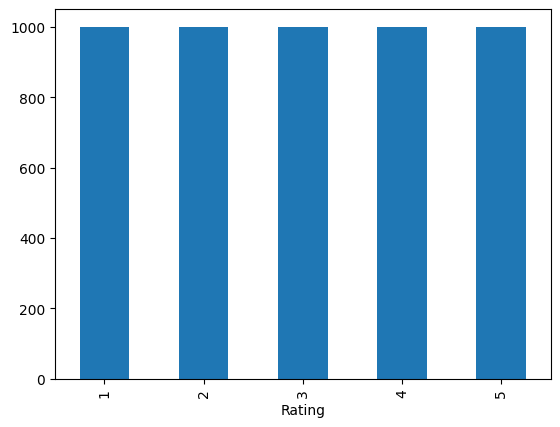

In [56]:
data['Rating'].value_counts().plot(kind='bar')

In [57]:
# split data into patients data doctors data and ratings

patients = data.columns[1:7]
data_patients = data[patients] # patients data
doctors = data.columns[7:15]
data_doctors = data[doctors] # doctors data
ratings = data.columns[15:]
data_ratings = data[ratings] # ratings

In [58]:
data_patients.describe()

,Patient ID,Patient Age,Patient Gender,Patient Health Condition,Previous Doctor Type,Last Appointment (Days)
count,5000.000000,5000.00000,5000.00000,5000.00000,5000.000000,5000.000000
mean,500.500000,40.14200,0.52700,52.11700,50.737000,155.263000
std,288.703862,23.41554,0.49932,29.01044,28.719589,86.804959
min,1.000000,0.00000,0.00000,0.00000,0.000000,1.000000
25%,250.750000,21.00000,0.00000,27.00000,26.000000,80.000000
50%,500.500000,39.00000,1.00000,52.00000,51.000000,160.000000
75%,750.250000,60.00000,1.00000,77.00000,76.000000,232.000000
max,1000.000000,80.00000,1.00000,100.00000,100.000000,300.000000


In [59]:
data_doctors.describe()

,Doctor ID,Doctor Age,Doctor Location,Doctor Type,Experience (Years),Patients in Lifetime,Patients in Queue,Pev_Visited
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2501.145800,72.142000,51.455000,49.948200,17.978274,1500.099033,30.005300,0.20000
std,288.613467,32.563629,32.306914,29.010568,9.214297,710.132120,14.176786,0.40004
min,2000.000000,0.000000,-38.000000,0.000000,0.001420,400.028351,8.001542,0.00000
25%,2251.750000,49.000000,27.000000,25.000000,10.415207,950.982514,19.034949,0.00000
50%,2506.000000,72.000000,52.000000,50.000000,17.872687,1497.256062,30.087614,0.00000
75%,2748.250000,95.000000,76.000000,76.000000,25.640173,2049.170021,41.007077,0.00000
max,2999.000000,144.000000,137.000000,100.000000,35.997055,2599.716065,51.999524,1.00000


In [60]:
data_ratings.describe()

,Rating
count,5000.000000
mean,3.000000
std,1.414355
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [61]:
# create datsets from the data
data_patients_train=data_patients.values[:4000]
data_patients_test=data_patients.values[4000:]

data_doctors_train=data_doctors.values[:4000]
data_doctors_test=data_doctors.values[4000:]

data_ratings_train=data_ratings.values[:4000]
data_ratings_test=data_ratings.values[4000:]

# patients data
train_dataset = tf.data.Dataset.from_tensor_slices((data_patients_train, data_doctors_train))
test_dataset = tf.data.Dataset.from_tensor_slices((data_patients_test, data_doctors_test))

# ratings data

train_labels = tf.data.Dataset.from_tensor_slices(data_ratings_train)
test_labels = tf.data.Dataset.from_tensor_slices(data_ratings_test)

# zip the datasets

train_dataset = tf.data.Dataset.zip((train_dataset, train_labels))
test_dataset = tf.data.Dataset.zip((test_dataset, test_labels))

# shuffle the datasets
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [62]:
train_dataset

<_BatchDataset element_spec=((TensorSpec(shape=(None, 6), dtype=tf.int64, name=None), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [63]:
test_dataset

<_BatchDataset element_spec=((TensorSpec(shape=(None, 6), dtype=tf.int64, name=None), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [64]:
def create_model(hp):
    lr=hp.Float('learning_rate',min_value=1e-6,max_value=1e-1,sampling='LOG',default=1e-3)
    unit1=hp.Int('unit1',min_value=32,max_value=128,step=32)
    unit2=hp.Int('unit2',min_value=32,max_value=64,step=32)
    unit3=hp.Int('unit3',min_value=32,max_value=64,step=32)
    unit4=hp.Int('unit4',min_value=16,max_value=32,step=32)
    input1=tf.keras.layers.Input(shape=(6,))
    input2=tf.keras.layers.Input(shape=(8,))

    a=tf.keras.layers.Dense(unit1,activation='relu')(input1)
    b=tf.keras.layers.Dense(unit1,activation='relu')(input2)

    b=tf.keras.layers.Dense(unit2,activation='relu')(b)
    a=tf.keras.layers.Dense(unit2,activation='relu')(a)

    a=tf.keras.layers.Dense(unit3,activation='relu')(a)
    b=tf.keras.layers.Dense(unit3,activation='relu')(b)

    c=tf.keras.layers.add([a,b])

    c=tf.keras.layers.Dense(unit4,activation='relu')(c)
    c=tf.keras.layers.Dense(6,activation='softmax')(c)

    model=tf.keras.models.Model(inputs=[input1,input2],outputs=c)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    return model

In [65]:
# tune the hyperparameters

import keras_tuner as kt

tuner=kt.Hyperband(create_model,objective='val_accuracy',max_epochs=10,overwrite=True,project_name='doctor_rating')

In [66]:
tuner.search(train_dataset,epochs=10,validation_data=test_dataset)

Trial 30 Complete [00h 00m 04s]
val_accuracy: 0.9169999957084656

Best val_accuracy So Far: 0.9470000267028809
Total elapsed time: 00h 01m 11s


In [67]:
model = tuner.get_best_models()[0]

In [68]:
# plot the model

tf.keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [69]:
# import the callbacks

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

checkpoint=ModelCheckpoint('recommender-ensemble.h5',monitor='loss',save_best_only=True)

earlystop=EarlyStopping(monitor='loss',patience=10)

reduce_lr=ReduceLROnPlateau(monitor='loss',factor=0.2,patience=1,min_lr=1e-6)


In [70]:
model.fit(train_dataset,epochs=10,validation_data=test_dataset,callbacks=[checkpoint])

Epoch 1/10


125/125 [==============================] - 1s 3ms/step - loss: 0.7959 - accuracy: 0.7005 - val_loss: 0.2220 - val_accuracy: 0.9300
Epoch 2/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3924 - accuracy: 0.8562 - val_loss: 0.2037 - val_accuracy: 0.9320
Epoch 3/10
125/125 [==============================] - 0s 2ms/step - loss: 0.4455 - accuracy: 0.7920 - val_loss: 0.2149 - val_accuracy: 0.9330
Epoch 4/10
125/125 [==============================] - 0s 2ms/step - loss: 0.2818 - accuracy: 0.8635 - val_loss: 0.7075 - val_accuracy: 0.8400
Epoch 5/10
125/125 [==============================] - 0s 2ms/step - loss: 0.4923 - accuracy: 0.7933 - val_loss: 1.7472 - val_accuracy: 0.8300
Epoch 6/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3414 - accuracy: 0.8680 - val_loss: 0.1961 - val_accuracy: 0.9460
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.4252 - accuracy: 0.8230 - val_loss: 0.3466 - val_accuracy: 0.9080
Epoch 8/10
125/12

In [71]:
# test the model
y_pred=model.predict(test_dataset)

32/32 [==============================] - 0s 710us/step


In [72]:
y_pred=np.array(y_pred)

In [73]:
y_pred=np.argmax(y_pred,axis=1)

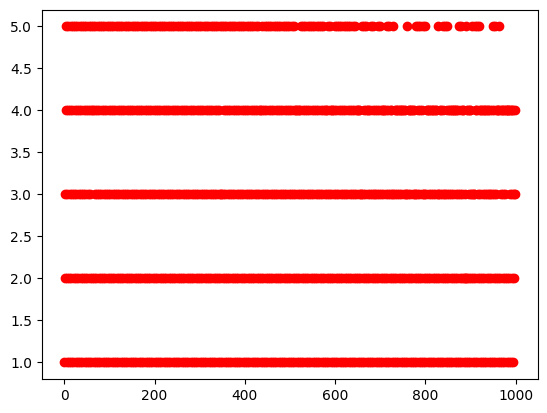

In [74]:
plt.scatter(range(len(y_pred)),y_pred,color='red')

In [75]:
y_true=np.fromiter(test_labels.as_numpy_iterator(),dtype=np.int32)

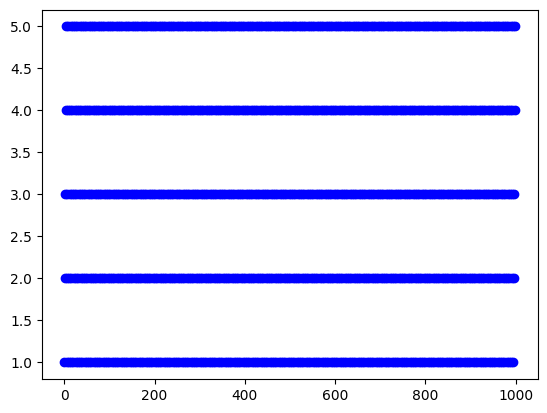

In [76]:
plt.scatter(range(len(y_pred)),y_true,color='blue')

<Axes: >

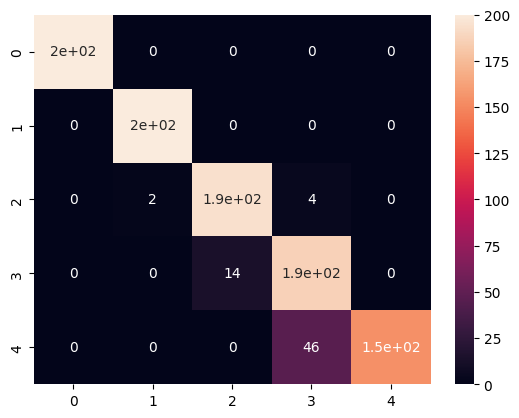

In [77]:
# confusion matrix in heat map

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)

import seaborn as sns
sns.heatmap(cm,annot=True)

In [79]:
model.save('recommender-ensemble.h5')